# JUDUL-Maylinna Rahayu Ningsih 4611421005
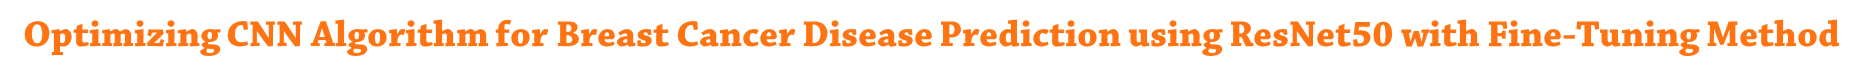

# IMPORT Library

In [ ]:
from tensorflow import keras
import cv2
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import pandas as pd

# SAMBUNG KE DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load dataset

In [ ]:
path = "/content/drive/MyDrive/Dataset_BUSI_with_GT (2)"
dir_list = [os.path.join(path,i) for i in os.listdir(path)]
size_dict = {}
for i,value in enumerate(dir_list):
    size_dict[os.listdir(path)[i]] = len(os.listdir(value))
size_dict

{'normal': 266, 'benign': 891, 'malignant': 421, '.ipynb_checkpoints': 0}

In [ ]:
from pathlib import Path

path = Path('/content/drive/MyDrive/Dataset_BUSI_with_GT (2)')
imageCount = len(list(path.glob('*/*.png')))
print(imageCount)


1578


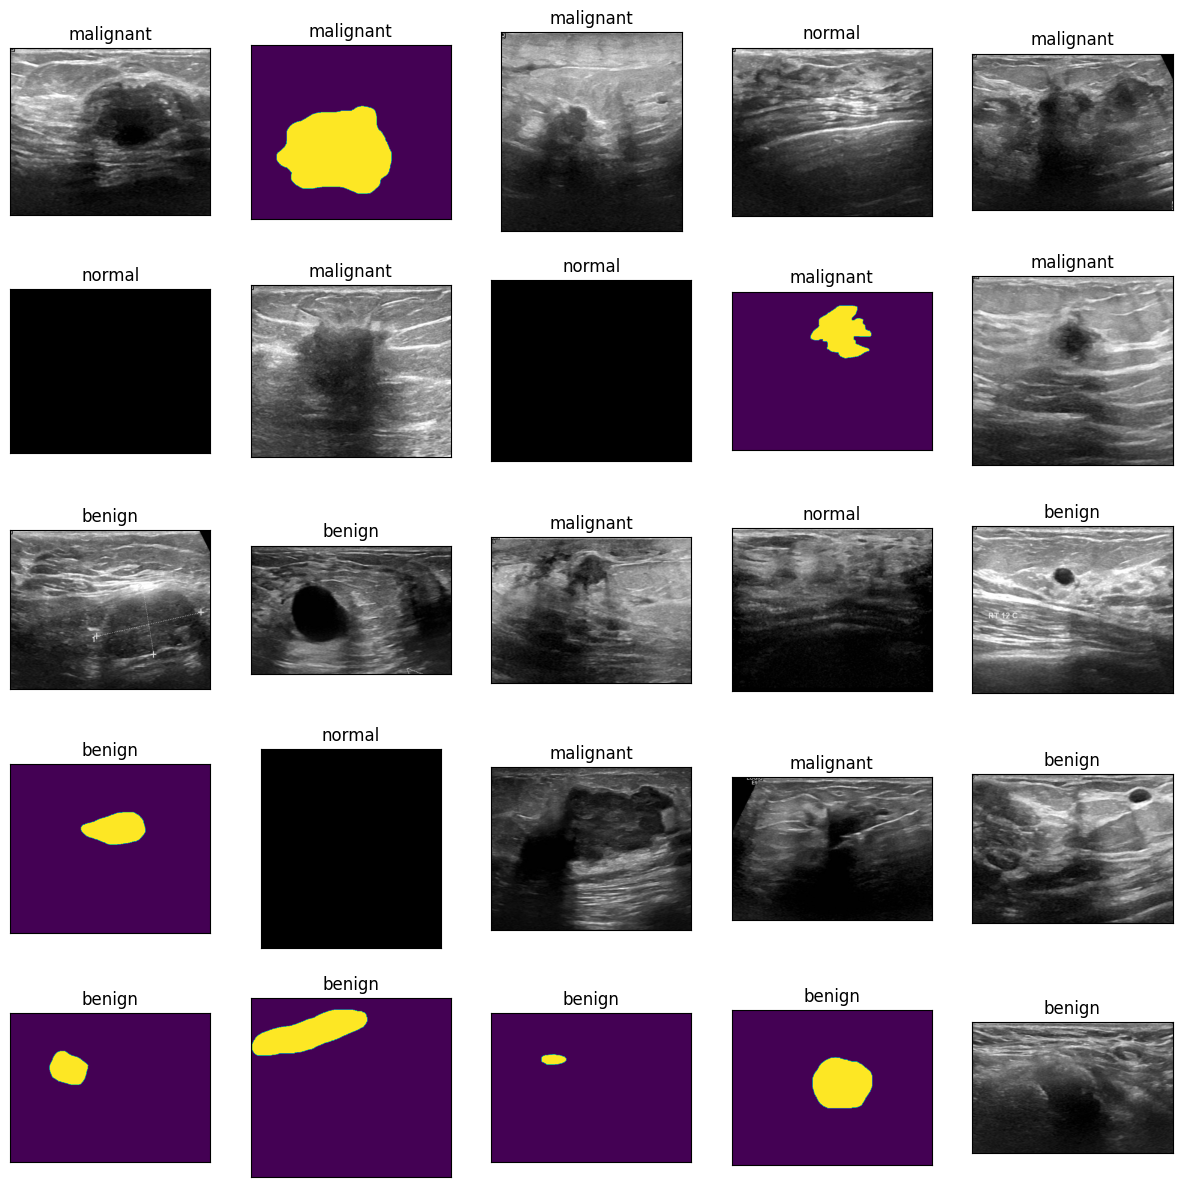

In [ ]:
import random
class_names = ['benign', 'malignant', 'normal']

plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    random_class = random.choice(class_names)
    img = plt.imread(random.choice(list(path.glob(random_class+"/*.png"))))
    plt.xticks([])
    plt.yticks([])
    plt.title(random_class)
    plt.imshow(img)

# Pre-Processing

In [ ]:
import re
def clean(name):
    name = re.sub('[benign ().p]','',str(name))
    return name

In [ ]:
img_size = 128
img_channel = 3
X_b , Xm_b , y_b = np.asarray(np.zeros((437,img_size,img_size,img_channel))) , np.asarray(np.zeros((437,img_size,img_size,img_channel))) , np.asarray(np.full(437,'benign') )
X_n , Xm_n , y_n = np.asarray(np.zeros((133,img_size,img_size,img_channel))) , np.asarray(np.zeros((133,img_size,img_size,img_channel))) , np.asarray(np.full(133,'normal') )
X_m , Xm_m , y_m = np.asarray(np.zeros((210,img_size,img_size,img_channel))) , np.asarray(np.zeros((210,img_size,img_size,img_channel))) , np.asarray(np.full(210,'malignant'))

In [ ]:
import os
img1_path = os.path.join(os.path.join(path,'benign'),os.listdir(os.path.join(path,'benign'))[1])

pil_img = load_img(img1_path,color_mode = 'rgb',target_size=(img_size,img_size))
img = img_to_array(pil_img)
img_shape = img.shape
print(img_shape)

def img_num(filename):

    val = 0

    for i in range(len(filename)) :
        if filename[i] == '(' :
            while True :
                i += 1
                if filename[i] == ')' :
                    break
                val = (val*10) + int(filename[i])
            break

    return val

for tumor_path in dir_list :
    for image in os.listdir(tumor_path) :
        p = os.path.join(tumor_path, image)
        pil_img = load_img(p,color_mode = 'rgb',target_size=(img_size,img_size))         # read image as  grayscale ans resize it

        if image[-5] == ')' :                                   #if real image

            if image[0] == 'b' :
                X_b[img_num(image)-1]+= img_to_array(pil_img)  # If image is real add it

            if image[0] == 'm' :
                X_m[img_num(image)-1]+= img_to_array(pil_img)
        else :                                                 #else masked image

            if image[0] == 'b' :
                Xm_b[img_num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                               # mask to y.
                Xm_n[img_num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                Xm_m[img_num(image)-1]+= img_to_array(pil_img)

(128, 128, 3)


In [ ]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
Xm = np.concatenate((Xm_b, Xm_n, Xm_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

print(X.shape)
print(Xm.shape)
print(y.shape)
X /= 255.0
Xm /= 255.0

print(X.max()) #Mencetak nilai maksimum dari array
print(Xm.min()) #encetak nilai minimum dari array

(780, 128, 128, 3)
(780, 128, 128, 3)
(780,)
1.0
0.0


# SPLIT DATA

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

encoder  = OneHotEncoder()
# y = y.toarray()
y=encoder.fit_transform(y.reshape(y.shape[0],1))

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.15,shuffle=True,random_state=42)
Xm_train,Xm_test,ym_train,ym_test = train_test_split(Xm,y,test_size = 0.15,shuffle=True,random_state=42,stratify=y.toarray())

class_list = encoder.categories_
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(663, 128, 128, 3) (117, 128, 128, 3)
(663, 3) (117, 3)


In [ ]:
from sklearn.metrics import f1_score,roc_auc_score,cohen_kappa_score
def evaluation(model,X_train,y_train,X_val,y_val,X_test,y_test,history):
    train_loss , train_acc = model.evaluate(X_train,y_train)
    val_loss, val_acc = model.evaluate(X_val,y_val)
    test_loss_value , test_accuracy = model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_label = np.argmax(y_pred,axis=1)
    y_true_label = np.argmax(y_test,axis=1)
    f1_measure = f1_score(y_true_label,y_pred_label,average='weighted')
    roc_score = roc_auc_score(y_test,y_pred)
    kappa_score = cohen_kappa_score(y_true_label,y_pred_label)
    print("Train accuracy = "+str(train_acc))
    print("Validation accuracy = "+str(val_acc))
    print('Test accuracy = ' + str(test_accuracy))
    print("f1_measure = "+str(f1_measure))
    print("KAPPA = "+str(kappa_score))
    print("roc_area = "+str(roc_score))

# UNTUK MENAMPILKAN nilai akurasi, loss, f1-score, roc-auc score, dan kappa score pada data latih, validasi, dan uji & plot visualisasi

In [ ]:
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split


def fit_evaluate(model,X_train,y_train,X_test,y_test,bs,Epochs,patience):
    es = EarlyStopping(monitor='val_loss', mode='min', patience=patience,restore_best_weights=True, verbose=1)
    X1_train,X_val,y1_train,y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=42,stratify = y_train.toarray())
    history = model.fit(X1_train,y1_train.toarray(),batch_size=bs,epochs=Epochs,validation_data=(X_val,y_val.toarray()), callbacks=[es])
    y_train_dense = y_train.toarray()
    y_test_dense = y_test.toarray()
    evaluation(model,X1_train,y1_train.toarray(),X_val,y_val.toarray(),X_test,y_test_dense,history)
    Train_Val_Plot(history.history['acc'],history.history['val_acc'],history.history['loss'],history.history['val_loss'])



#model ResNet50  

---



1.  Memuat arsitektur model ResNet50 dari TensorFlow yang sudah dilatih pada dataset ImageNet dan menggunakannya sebagai base model untuk transfer learning pada tugas pengenalan gambar.
2. Setelah model ResNet50 dimuat, kode tersebut menonaktifkan training untuk semua layer pada model ResNet50 menggunakan loop for dan statement layer.trainable = False.

Hal ini dilakukan untuk mempertahankan bobot yang sudah dilatih dari ResNet50 dan mencegah perubahan pada model base saat melatih model di atasnya pada tugas pengenalan gambar.

In [ ]:
import tensorflow as tf
base_model = tf.keras.applications.ResNet50(
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                input_shape=img_shape,
                pooling=None,
            )
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
def resnet():

    model = Sequential()
    model.add(base_model)

    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3,activation='softmax'))

    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

    return model

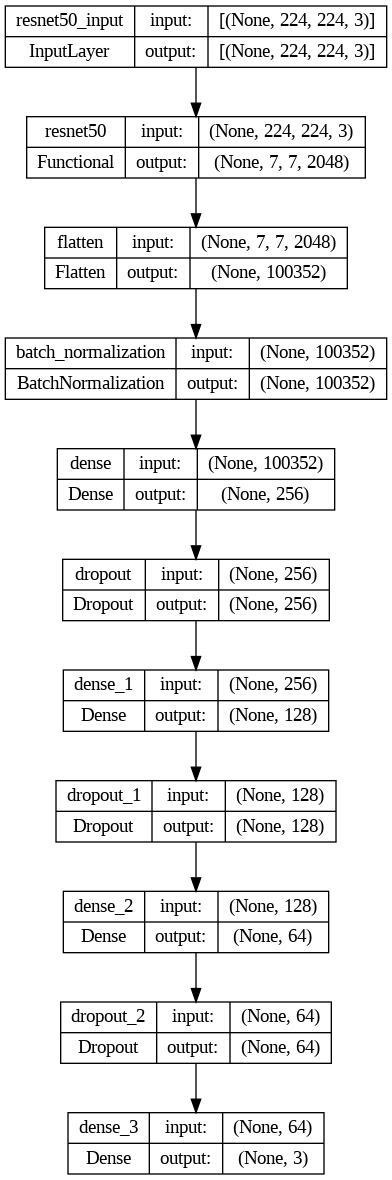

In [ ]:
from tensorflow.keras.utils import plot_model

# Generate model diagram
plot_model(model, to_file='model_diagram.png', show_shapes=True)



# training dan evaluasi model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 batch_normalization (BatchN  (None, 32768)            131072    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

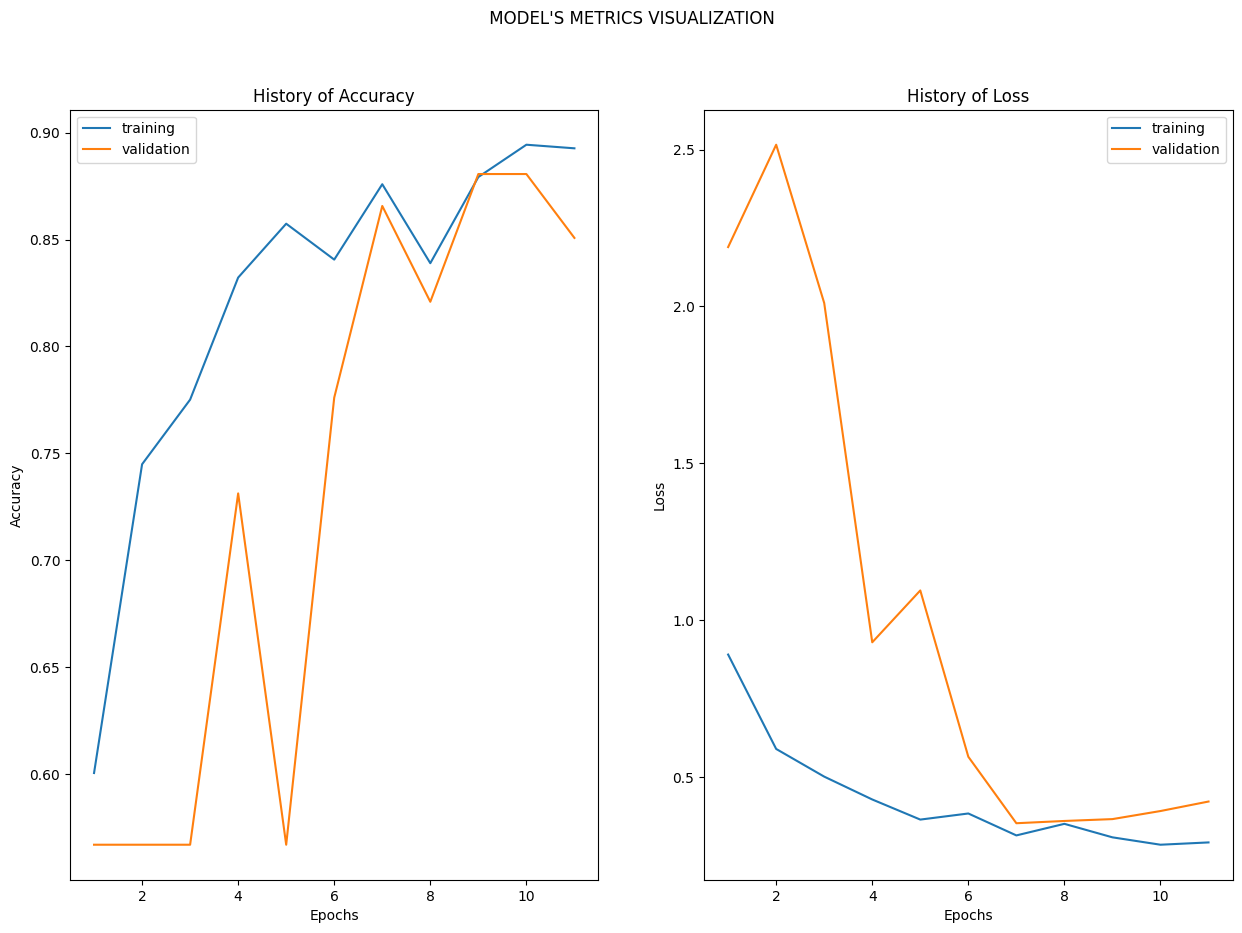

In [ ]:

model = resnet()
model.summary()

fit_evaluate(model, X_train, y_train, X_test, y_test, 16, 30, 4)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = resnet()
model.summary()

def fit_evaluate(model, X_train, y_train, X_test, y_test, bs, Epochs, patience):
    es = EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True, verbose=1)
    X1_train, X_val, y1_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train.toarray())
    history = model.fit(X1_train, y1_train.toarray(), batch_size=bs, epochs=Epochs, validation_data=(X_val, y_val.toarray()), callbacks=[es])
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_pred_binary = np.argmax(y_train_pred, axis=1)
    y_test_pred_binary = np.argmax(y_test_pred, axis=1)
    y_train_true_binary = np.argmax(y_train.toarray(), axis=1)
    y_test_true_binary = np.argmax(y_test.toarray(), axis=1)
    train_accuracy = accuracy_score(y_train_true_binary, y_train_pred_binary)
    train_precision = precision_score(y_train_true_binary, y_train_pred_binary, average='weighted')
    train_recall = recall_score(y_train_true_binary, y_train_pred_binary, average='weighted')
    train_f1 = f1_score(y_train_true_binary, y_train_pred_binary, average='weighted')
    test_accuracy = accuracy_score(y_test_true_binary, y_test_pred_binary)
    test_precision = precision_score(y_test_true_binary, y_test_pred_binary, average='weighted')
    test_recall = recall_score(y_test_true_binary, y_test_pred_binary, average='weighted')
    test_f1 = f1_score(y_test_true_binary, y_test_pred_binary, average='weighted')
    print("Training Set:")
    print("Accuracy:", train_accuracy)
    print("Precision:", train_precision)
    print("Recall:", train_recall)
    print("F1 Score:", train_f1)
    print("Test Set:")
    print("Accuracy:", test_accuracy)
    print("Precision:", test_precision)
    print("Recall:", test_recall)
    print("F1 Score:", test_f1)

fit_evaluate(model, X_train, y_train, X_test, y_test, 16, 30, 4)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 32768)            131072    
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 256)               8388864   
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                      

# FINE TUNING

In [ ]:
X_train = Xm_train
y_train = ym_train
X_test = Xm_test
y_test = ym_test
model = resnet()
model.summary()

def fit_evaluate(model,X_train,y_train,X_test,y_test,bs,Epochs,patience):
    es = EarlyStopping(monitor='val_loss', mode='min', patience=patience,restore_best_weights=True, verbose=1)
    X1_train,X_val,y1_train,y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=42,stratify = y_train.toarray())
    history = model.fit(X1_train,y1_train.toarray(),batch_size=bs,epochs=Epochs,validation_data=(X_val,y_val.toarray()), callbacks=[es])
    y_train_dense = y_train.toarray()
    y_test_dense = y_test.toarray()
    evaluation(model,X1_train,y1_train.toarray(),X_val,y_val.toarray(),X_test,y_test_dense,history)
    Train_Val_Plot(history.history['acc'],history.history['val_acc'],history.history['loss'],history.history['val_loss'])



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 batch_normalization_5 (Batc  (None, 32768)            131072    
 hNormalization)                                                 
                                                                 
 dense_20 (Dense)            (None, 256)               8388864   
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                      

In [ ]:
fit_evaluate(model, Xm_train, ym_train, Xm_test, ym_test, 16, 50, 4)


Epoch 1/50
38/38 [==============================] - 2s 40ms/step - loss: 0.2460 - acc: 0.9044 - val_loss: 0.5539 - val_acc: 0.6866
Epoch 2/50
38/38 [==============================] - 1s 33ms/step - loss: 0.2569 - acc: 0.9144 - val_loss: 0.2815 - val_acc: 0.8806
Epoch 3/50
38/38 [==============================] - 1s 30ms/step - loss: 0.2142 - acc: 0.9279 - val_loss: 0.4878 - val_acc: 0.8209
Epoch 4/50
38/38 [==============================] - 1s 31ms/step - loss: 0.2563 - acc: 0.9144 - val_loss: 0.2946 - val_acc: 0.8955
Epoch 5/50
38/38 [==============================] - 1s 29ms/step - loss: 0.2496 - acc: 0.9279 - val_loss: 0.3066 - val_acc: 0.8507
Epoch 6/50
38/38 [==============================] - 1s 33ms/step - loss: 0.2119 - acc: 0.9346 - val_loss: 0.3636 - val_acc: 0.8806
Epoch 6: early stopping
4/4 [==============================] - 0s 30ms/step
Training Set:
Accuracy: 0.9653092006033183
Precision: 0.9656377205655201
Recall: 0.9653092006033183
F1 Score: 0.9649542683434386
Test Set:

# PREDIKSI

In [ ]:
import cv2
img = cv2.imread('/content/drive/MyDrive/Dataset_BUSI_with_GT (2)/benign/benign (1).png')
img = cv2.resize(img,(128,128))
img = np.reshape(img,[1,128,128,3])

#classes = model.predict_classes(img)
predict_x=model.predict(img)
classes=np.argmax(predict_x,axis=1)

print (classes)



1/1 [==============================] - 1s 933ms/step
[0]


4/4 [==============================] - 0s 46ms/step


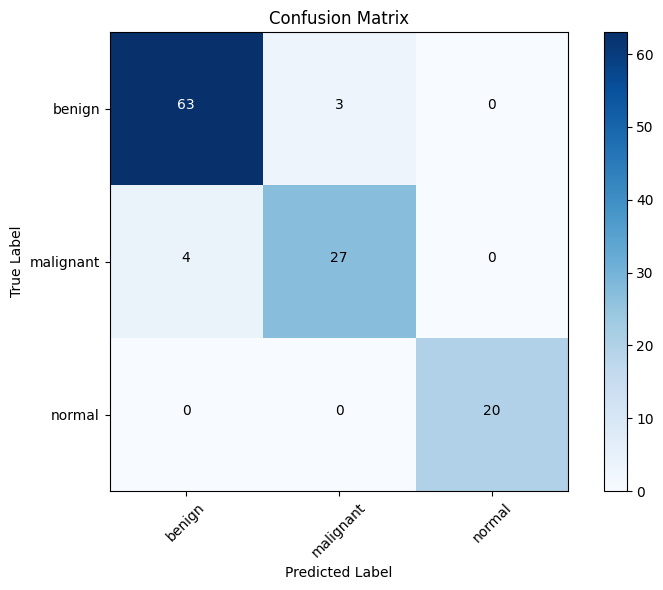

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ubah label prediksi menjadi bentuk one-hot encoding
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ubah label ground truth menjadi bentuk one-hot encoding
y_true_labels = np.argmax(y_test, axis=1)

# Ubah label prediksi dan ground truth menjadi array numpy
y_pred_labels = np.asarray(y_pred_labels)
y_true_labels = np.asarray(y_true_labels)

# Hitung confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = encoder.categories_[0]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Tampilkan angka di dalam sel confusion matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


Pada confusion matrix yang diberikan, baris sumbu y mewakili label sebenaranya yakni benign, malginant
dan normal. Sedangkan untuk Sumbu X mewakili label yang di prediksi. Terlihat bahwa model memiliki
tingkat akurasi yang tinggi, terutama dalam memprediksi kelas benign dan malginant. Terdapat 63 prediksi
benign yang benar dan 27 prediksi malginant yang benar. Namun terdapat beberapa kesalahan dalam
prediksi, dimana ada 3 prediksi benign yang salah di klasifikasikan sebagai malginant dan 4 prediksi
malginant yang salah diklasifikasikan sebagai benign. Untuk kelas normal, model berhasil memprediksi
dengan sempurna tanpa adanya kesalahan.

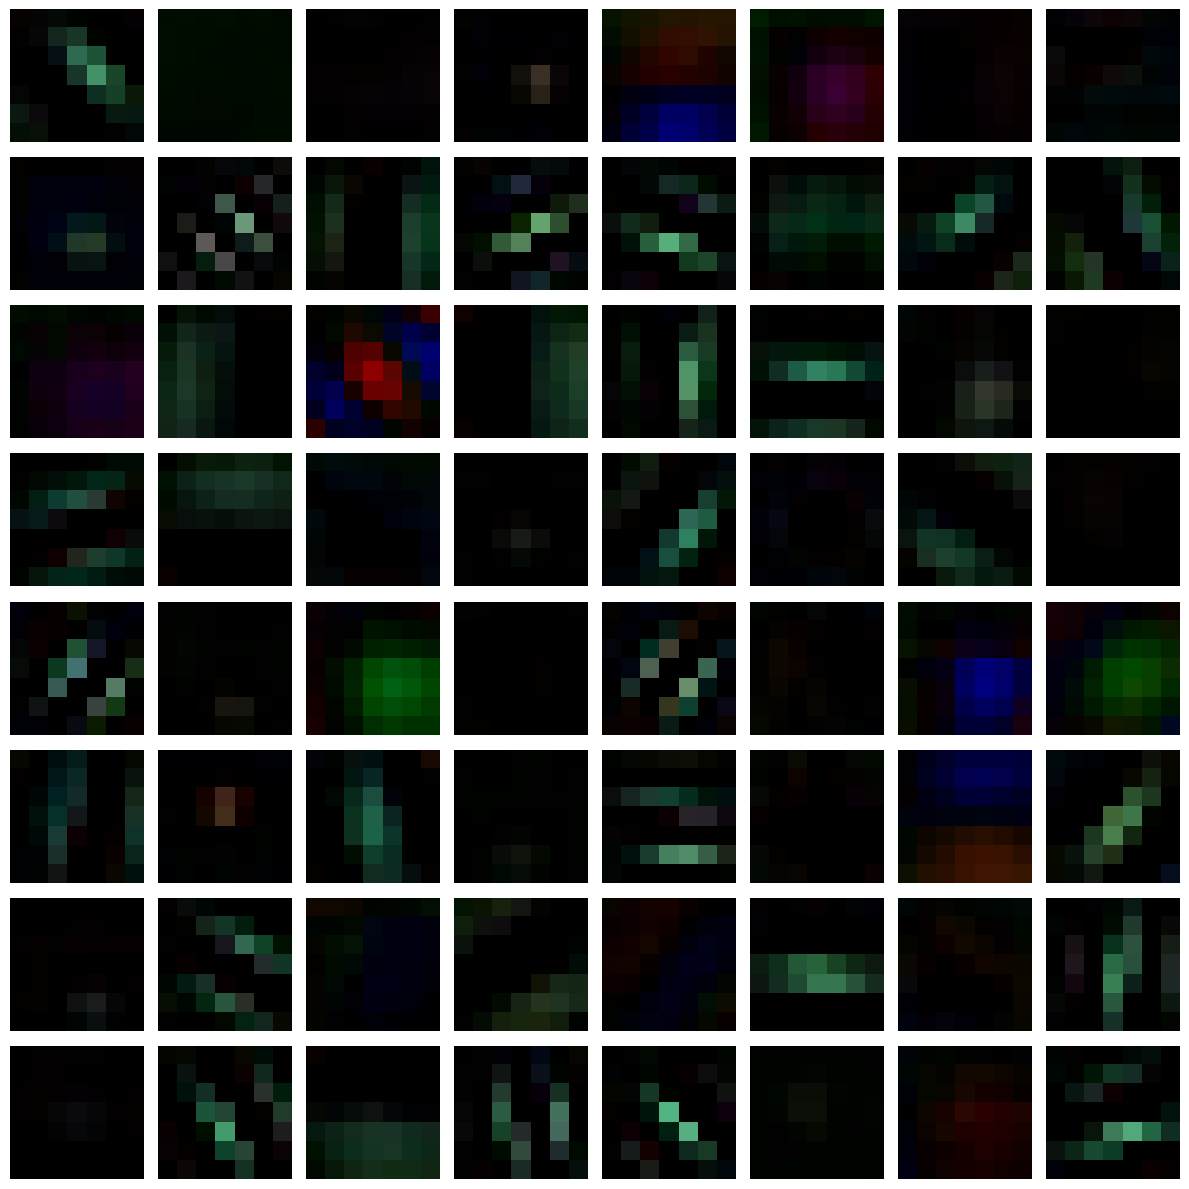

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Ambil layer konvolusi pertama dari model ResNet50
conv1_layer = None
for layer in model.layers[0].layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        conv1_layer = layer
        break

if conv1_layer is None:
    print("Layer konvolusi pertama tidak ditemukan.")
    exit()

# Ambil bobot filter dari layer konvolusi pertama
filters = conv1_layer.get_weights()[0]

# Tampilkan beberapa filter
num_filters = filters.shape[3]
rows = int(np.sqrt(num_filters))
cols = int(np.ceil(num_filters / rows))

fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

for i, ax in enumerate(axes.flatten()):
    if i < num_filters:
        # Ambil filter ke-i
        filter_img = filters[:, :, :, i]
        filter_img = np.squeeze(filter_img)

        # Tampilkan filter
        ax.imshow(filter_img)
        ax.axis('off')

plt.tight_layout()
plt.show()


mencari layer konvolusi pertama dalam model ResNet50 dan mengambil bobot filter dari layer tersebut. Kemudian, beberapa filter akan ditampilkan sesuai dengan jumlah filter yang ditemukan.

In [ ]:
last_layer = model.layers[-1]
print(last_layer)


1/1 [==============================] - 1s 964ms/step


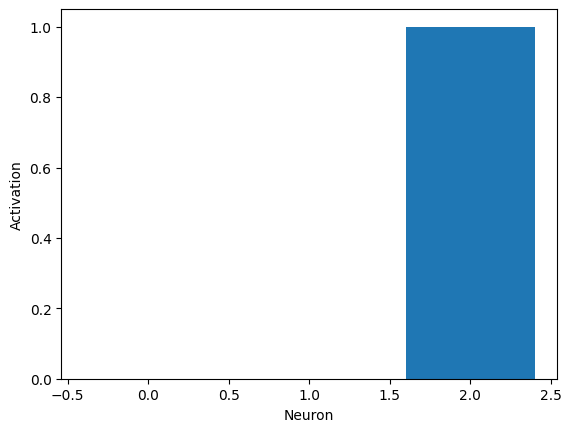

In [ ]:
import matplotlib.pyplot as plt

# Mendefinisikan model yang hanya mencakup layer terakhir
last_layer_model = keras.models.Model(inputs=model.input, outputs=model.layers[-1].output)

# Mengambil input gambar
input_image = X[0]  # Ubah ini sesuai dengan input gambar yang ingin digunakan

# Melakukan prediksi menggunakan model
activations = last_layer_model.predict(np.expand_dims(input_image, axis=0))

# Menampilkan visualisasi aktivasi
plt.bar(range(len(activations.squeeze())), activations.squeeze())
plt.xlabel('Neuron')
plt.ylabel('Activation')
plt.show()



4/4 [==============================] - 0s 47ms/step


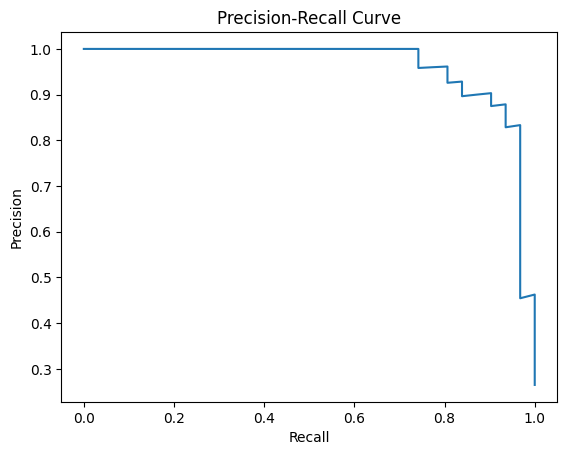

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Mengubah y_test menjadi array dense
y_test_dense = y_test.toarray()

# Mendapatkan probabilitas prediksi kelas positive dari model
y_pred = model.predict(X_test)
y_scores = y_pred[:, 1]  # Probabilitas prediksi kelas positive

# Mendapatkan presisi, recall, dan threshold menggunakan precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test_dense[:, 1], y_scores)

# Menggambar kurva precision-recall
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
